#### 1. Introduction


<img src="../files/images/cnn.jpg">

In deep learning, a convolutional neural network (CNN/ConvNet) is a class of deep neural networks, most commonly applied to analyze visual imagery. CNNs are often used for image-related AI applications, such as image classification, detection, and segmentation. They can also be used for other AI tasks, such as natural language processing and recommendation engines. This project uses the FASHION MNIST dataset availale in Keras [https://keras.io/api/datasets/fashion_mnist/] implement a CNN using Keras and Python. The model can later be adaptedfor user profile classification. The objectives of the project are to:

- Use Keras and classes to develop a CNN with six layers to classify the Fashion MNIST dataset.
- Make predictions for at least two images from the Fashion MNIST dataset.

Dataset:

The FASHION MNIST dataset comprises of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more. The mapping of all 0-9 integers to class labels is listed below.

- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

The Fashion MNIST dataset is a popular dataset used for machine learning and computer vision tasks.

#### 2. Setup and Importing Libraries
We will start by loading and importing the relevant libraries for our task. These will include data manipulation libraries, visualization libraries and machine learning libraries.

In [1]:
import keras
import tensorflow as tf
import ssl
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from urllib import request

#### 3. Loading and Exploring the Data

In [3]:
# Disable SSL verification

ssl._create_default_https_context = ssl._create_unverified_context

# Load Fashion MNIST dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# Call the function to load the dataset
trainX, trainY, testX, testY = load_dataset()

# Print the dataset to see the shape
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

Train: X=(60000, 28, 28, 1), y=(60000, 10)
Test: X=(10000, 28, 28, 1), y=(10000, 10)


Calling the function on the Fashion-MNIST train and test dataset, and printing the shape, we see that there are 60,000 examples in the training dataset and 10,000 in the test dataset. The images are squares of 28×28 pixels. Next we plot a few images to visualize how they look like.

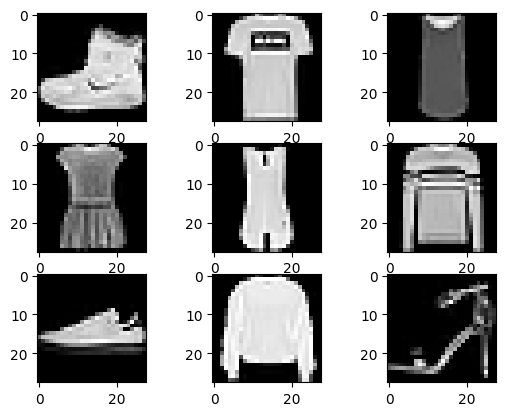

In [4]:
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

The items are displayed in grayscale and are cloth items ranging from shoes to tshirts etc as described in the dataset.

#### 4. Data Preprocessing

##### Normalizing the data
Scaling is an important step in deep learning since it improves the model performance. We will create a function to scale our dataset. We normalize the pixel values of the images  from (0, 255) to a range (0,1).

In [5]:
#Scale the pixels
def scale_pixels(train, test):
    # We first convert them from integers to floats
    
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    #Then normalize them to a range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    return train_norm, test_norm

In [6]:
# Call the function to scale the pixels
trainX, testX = scale_pixels(trainX, testX)

#### 5. Building the CNN Model

##### Defining the Model

We start by defining a base CNN model. The model has two key features.

- The feature extraction front end that has the convolutional and pooling layers
- The classifier backend that will make a prediction.

To understand the basics of a CNN, the following important concepts must be understood: [https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide]

- Convolutional Layers: They learn to detect various image features using filters.
- Pooling Layers: Pooling layers make the network computationally efficient by reducing the spatial dimensions of the feature maps.
- Fully Connected Layers: They perform classification based on the features extracted by the convolutional and pooling layers.
- Activation Functions: Functions like ReLU and Sigmoid introduce non-linearity into the network, enabling it to learn complex patterns.
- Loss Functions: These functions measure the error between predicted and actual labels, guiding the optimization process.

<img src="../files/images/cnn_architecture.png">

In [7]:
def model_definition():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

We have defined a model with six layers:

- Conv2D layer: 32 filters, kernel size of (3, 3), with ReLU (Rectified Linear Unit) activation.
- MaxPooling2D layer: Pooling size of (2, 2).
- Flatten layer: Flattens the output from the previous layer into a 1D vector.
- Dense layer: 100 neurons, with ReLU activation.
- Dense layer: 10 neurons, with softmax activation for classification.
- Input layer (implicitly defined by input_shape parameter in the first layer).

In [8]:
# Evaluate a model using k-fold cross-validation
def model_evaluation(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        
        # define model
        model = model_definition()
        
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        
        # append scores
        scores.append(acc)
        histories.append(history)
        return scores, histories

In [9]:
# Call function to evaluate the model
scores, histories = model_evaluation(trainX, trainY)

2024-11-14 18:18:56.401392: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dominic/Downloads/Nexford_University/Programming_in_R_and_Python/module_6/cnn-fashion-mnist/venv/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


> 90.900


The model achieves an accuracy of 90.9%. 

#### 7. Saving the Model and Results

In [10]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        pyplot.show()

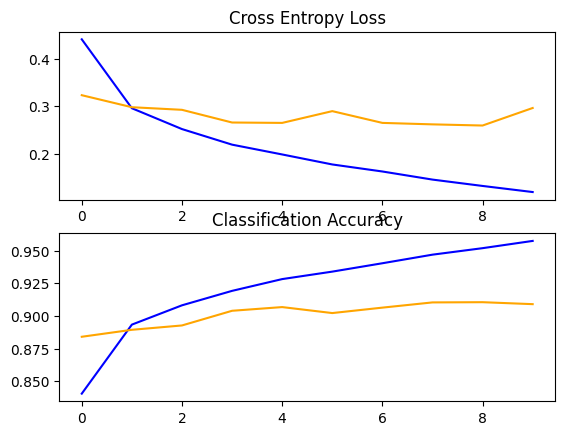

In [11]:
summarize_diagnostics(histories)

A cross-entropy curve is used to evaluate the cross-entropy loss value on the y-axis and the number of training iterations or epochs on the x-axis. The curve provides insights on how well the model is learning and is effective in showing issues such as overfitting and underfitting. For classification tasks, the Cross-entropy loss measures the difference between actual labels and predicted probabilities.

- Training Loss: The blue line shows a steady decrease in cross-entropy loss as the number of epochs increases. This indicates that the model is learning well and getting better at making the prediction.
- Vaildation Loss (Orange line): Initially decreases but flattens. The indication is that the model is not improving a lot on the validation data and could potentially indicate an overfitting on the training data.

The decreasing training loss and increasing training accuracy and the slight increase in validation loss indicates that the model could be overfitting on the training data. It is doing a poor job at generalizing on the validation data.


In [17]:
# Summarizing model performance
def model_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))


In [18]:
model_performance(scores)

Accuracy: mean=90.900 std=0.000, n=1


##### Saving the model

In [14]:
# Define the model
model = model_definition()

# fit model
model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

/Users/dominic/Downloads/Nexford_University/Programming_in_R_and_Python/module_6/cnn-fashion-mnist/venv/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [15]:
# save model
model.save('final_fashion_mnist_model.h5')

##### Making a prediction

In [33]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [48]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

def predict_example():
    
    # load the image
    img = load_image('../images/socks.jpeg')
    
    # load model
    model = load_model('final_fashion_mnist_model.h5')
    
    # predict the class
    predictions = model.predict(img)
    result = np.argmax(predictions, axis=-1)
    
    # Display the image with the predicted label
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Predicted Class: {result}")
    plt.axis('off')
    plt.show()
    
#     print(result[0])

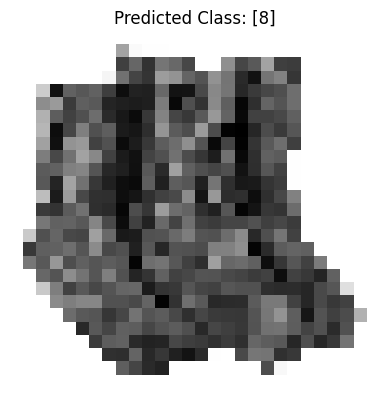

In [49]:
#Call the predict function
predict_example()

The model incorrectly identifies the class as 8 (Bag). But the original image was a pair of socks.

#### 8. Summary and Next Steps

The model can be improved further for instance by :
- Increasing the number of filters used in the convolutional layer
- Adding padding to the convolutional operation often improves model performance.
- Early stopping to prevent overfitting.
